In [37]:
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime
import re
import numpy as np

from together import Together  # pip install together

from Functions import get_gentrification_scores, map_static, get_gentrification_scores_categorical

In [38]:
city = 'manchester'

## Read in data

Data were downloaded for Bristol from [Inside AirBnB](https://insideairbnb.com/get-the-data/) from a snapshot taken on 23 September, 2024. I use the three 'details' files:
   - `listings.csv.gz`
   - `reviews.csv.gz`
   - `neighbourhoods.geojson`

The downloaded files need to be placed in a directory called [airbnb-bristol](./airbnb-bristol) in the same directory as this script (not uploaded to github).

In [5]:
listings = pd.read_csv(f"../../data/airbnb-{city}/listings.csv.gz")
reviews = pd.read_csv(f"../../data/airbnb-{city}/reviews.csv.gz")
neighbourhoods = gpd.read_file(f"../../data/airbnb-{city}/neighbourhoods.geojson")

# Use the lat/lon columsn to make the listings a geodataframe
listings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude))

In [6]:
print(f"Have read {len(listings)} listings, {len(reviews)} reviews, and {len(neighbourhoods)} neighbourhoods.\n"
      f"They were last scraped on {listings.last_scraped.min()}.")

assert len(listings.last_scraped.unique()) == 1, "For some reason there are multiple last_scraped dates in the listings file."

Have read 6811 listings, 226624 reviews, and 41 neighbourhoods.
They were last scraped on 2024-12-25.


/nfs/a319/gy17m2a/INTEGRATE/llm/python/Molly/Functions.py:149: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  df.plot(ax=ax, column=column, markersize=1.5, color='red', alpha=1, zorder=2, )


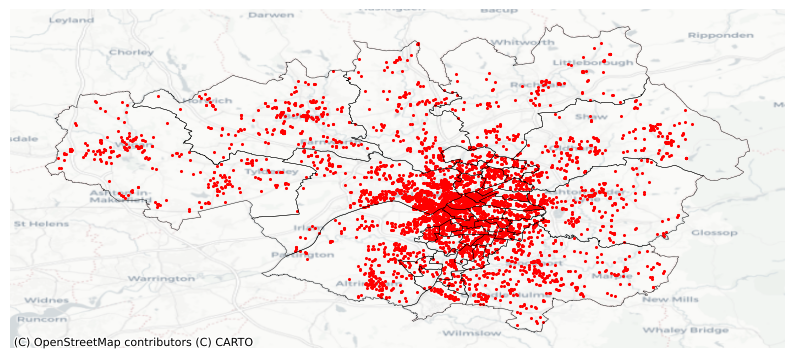

In [7]:
map_static(neighbourhoods, listings, 'id')

## Combine description and neighbourhood overview into one text column

In [9]:
listings = pd.read_csv(f"../../data/airbnb-{city}/listings.csv.gz")
# We need a single 'text' column later. Combine the listing text and the neighbourhood overview

listings['text'] = np.where(
    listings[['description', 'neighborhood_overview']].isna().all(axis=1),  # Check if both are NaN
    np.nan,  # Assign NaN if both are NaN
    listings['description'].fillna('') + " " + listings['neighborhood_overview'].fillna(''))

listings[listings['text'].isna()][["description", "neighborhood_overview","text"]].head()

print(len(listings))

6811


### The Prompt

In [10]:
prompt_explanatory = f"""
You are an expert in urban studies with a deep understanding of gentrification and its portrayal in public discourse. I will provide you with Airbnb 
listings, including a description of the property and a neighborhood overview. Your task is to analyze these texts and assess the gentrification status 
of the area based on how the neighborhood is presented.

Focus primarily on the neighborhood overview and description, ignoring property-specific details like the number of bedrooms, amenities, or decor. 

Consider the following:
- Direct mentions of local attractions, businesses, or community features that suggest development or revitalization.
- Language that highlights cultural hotspots, boutique shops, trendy cafes, or artisanal markets.
- Descriptions that emphasize diversity, safety, or the presence of creative communities, as these can signal gentrification dynamics.
- Listings that avoid mentioning the neighborhood or speak only broadly about the city may imply that the immediate area lacks desirable features or is 
not a selling point. This absence of detail should inform your assessment.

Assign one of the following categories:
- "Established": A well-known, desirable area with stable appeal and little active change.
- "Gentrifying": Signs of recent or ongoing transformation, such as new businesses or cultural shifts.
- "Emerging": Early indicators of gentrification potential, like creative spaces or gradual commercial interest.
- "Undeveloped": Lacking indicators of gentrification, often reflected in vague or absent neighborhood descriptions.

If a listing genuinely lacks sufficient information to make any assessment (e.g., the text is too sparse), assign a score of 'NA' and briefly explain.

Provide your answer strictly in the format:
'1. Category. Reasoning.', '2. Category. Reasoning.', etc., without any additional explanation or commentary.
"""
prompt = prompt_explanatory

In [23]:
# prompt_explanatory = f"""
# You are an expert in urban studies with a deep understanding of what makes a neighborhood desirable and well-appointed. I will provide you with 
# some Airbnb listings, including a description of the property and a neighborhood overview. Your task is to analyze the neighborhood overview and 
# description, and determine the extent to which it suggests that the neighborhood or area referenced is upscale, well-maintained, and well-served by 
# amenities. Please focus primarily on the neighborhood overview and description, rather than the property's amenities or features. Disregard 
# descriptions of the property's amenities, such as number of bathrooms or appliances. If the listing mentions the city or region as a whole, uses 
# phrases like '{city} has a vibrant cultural scene' or 'the city is known for its historic landmarks', or describes amenities or attractions that are 
# not specific to the local neighborhood, please assign a score of 'NA' and explain that the listing is not focused on the local neighborhood, or just 
# use the information provided which is focused on the local neighbourhood. Similarly, if the listing lacks sufficient information to make an informed 
# judgment about the neighborhood's desirability, please assign a score of 'NA' and provide a brief explanation. Consider not only explicit mentions of 
# upscale features, such as high-end restaurants, boutique shops, or luxury amenities, but also subtle hints or suggestions that a neighborhood may be 
# well-appointed and desirable. When evaluating the listing, pay attention to the tone and language used, and consider the potential biases and 
# motivations of the lister. Look for subtle hints, such as coded language or omissions, that may suggest a neighborhood is not as upscale as it seems. 
# Otherwise, assign a score from 1 to 5, where 1 means not suggestive of an upscale neighborhood and 5 means highly suggestive. Explain your reasoning 
# in 1-2 sentences, referencing the specific words or phrases in the listing that led you to your conclusion. Provide your answer strictly in the 
# format ‘1. Score. Reasoning.’, ‘2. Score. Reasoning’, '3. Score. Reasoning', etc., without any additional explanation or commentary
# """
# prompt = prompt_explanatory

In [24]:
# # This prompt asks explicitly for an explanation (note may need to make sure that 'max_tokens' in the call to the API is sufficiently large
# prompt_explanatory = f"""
# You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with 
# some Airbnb listings, including a description of the property and a neighborhood overview. Your task is to analyze the neighborhood overview and 
# description, and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Please focus 
# primarily on the neighborhood overview and description, rather than the property's amenities or features. Disregard descriptions of the property's
# amenities, such as number of bathrooms or appliances. If the listing mentions the city or region as a whole, uses phrases like '{city} has a 
# vibrant cultural scene' or 'the city is known for its historic landmarks', or describes amenities or attractions that are not specific to the local 
# neighborhood, please assign a score of 'NA' and explain that the listing is not focused on the local neighborhood, or just use the information provided
# which is focused on the local neighbourhood. Similarly, if the listing lacks sufficient information to make an informed judgment about gentrification,
# please assign a score of 'NA' and provide a brief explanation.  Consider not only explicit mentions of gentrification indicators, such as new businesses,
# urban renewal, or changes in local demographics, but also subtle hints or suggestions that a neighborhood may be experiencing gentrification, or 
# conversely, that it may be resisting or unlikely to experience gentrification. When evaluating the listing, pay attention to the tone and language used,
# and consider the potential biases and motivations of the lister. Look for subtle hints, such as coded language or omissions, that may suggest a 
# neighborhood is not as gentrified as it seems. Otherwise, assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly
# suggestive. Explain your reasoning in 1-2 sentences, referencing the specific words or phrases in the listing that led you to your conclusion. Provide 
# your answer strictly in the format ‘1. Score. Reasoning.’, ‘2. Score. Reasoning’, '3. Score. Reasoning', etc., without any additional explanation or
# commentary 
# """

# # The propmpt to use (sometimes I have a few to choose between)
# prompt = prompt_explanatory

## Decide whether to run LLM
Decide whether to run the LLM or load a file of scores that has been previously calculated and saved

In [12]:
# Check for existing files
base_dir = os.path.expanduser(f"../../data/airbnb-{city}/")
base_filename = "airbnb_gentrification_scores_categorical2"
file_extension = ".gpkg"

# List all matching files in the directory
matching_files = [
    f for f in sorted(os.listdir(base_dir))
    if re.match(f"{base_filename}_\\d{{2}}{file_extension}$", f)]
matching_files

[]

In [13]:
# If there are matching files, find the most recent one
if matching_files:
    df = gpd.read_file(base_dir+matching_files[-1])
    print(f"Loaded file: {matching_files[-1]}")
else:
    # If no matching files are found
    print("No matching files found. 'df' will not be loaded.")
    df = None

No matching files found. 'df' will not be loaded.


In [40]:
df.to_csv(f"{filepath}")

In [36]:
RUN_LLM = True
if df is not None:
    print("Have already loaded a gentrification file, will not re-run the LLM.")
    RUN_LLM = False

RUN_LLM = True  # Optionally override

if RUN_LLM:
    print("Running LLM")
    # Get the API key from a file
    with open('together.ai_key.txt', 'r') as f:
        api_key = f.readline().strip()

    client = Together(api_key=api_key)

    # Sample for now?
    #df = listings.sample(50).copy()
    df = listings.copy()

    print(f"Will query the LM for {len(df)} items")

    assert len(df) < 7000, "Too many tweets to process in one go. Please reduce the number of tweets."

    # Ensure the index is consecutive and ascending
    df = df.reset_index(drop=True)
    # To store the results
    df['gentrification_prediction'] = None

    # Batch processing
    batch_size = 20
    for i in range(0, len(df), batch_size):
        # Get the batch of tweets
        batch_tweets = df.loc[i:i + batch_size - 1, :]

        # Get sentiments using the function
        print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

        ids, sentiments, explanations = get_gentrification_scores_categorical(
            batch_tweets, prompt, client, batch_index=i, max_tokens=1500)
        # Update the DataFrame with the predictions
        df.loc[ids, 'gentrification_prediction'] = sentiments
        df.loc[ids, 'explanation'] = explanations

        # Predictions should be integers
        # df.gentrification_prediction = df.gentrification_prediction.astype('Int64')

    print("Finished querying LLM. Now saving file")

    # Initialize counter and check for existing files
    counter = 1
    while True:
        filename = f"{base_filename}_{counter:02d}.csv"
        filepath = os.path.join(base_dir, filename)
        if not os.path.exists(filepath):
            break
        counter += 1
    df.to_csv(f"{filepath}")    
    # df.set_crs(epsg=4326, inplace=True)
    # df.to_file(filepath, layer="data", driver="GPKG")
    print(f"File saved as: {filepath}")

Have already loaded a gentrification file, will not re-run the LLM.
Running LLM
Will query the LM for 6811 items
Submitting batch 1 of 340...
Submitting batch 2 of 340...
Submitting batch 3 of 340...
Submitting batch 4 of 340...
Submitting batch 5 of 340...
Submitting batch 6 of 340...
Submitting batch 7 of 340...
Submitting batch 8 of 340...
Submitting batch 9 of 340...
Submitting batch 10 of 340...
Submitting batch 11 of 340...
Submitting batch 12 of 340...
Submitting batch 13 of 340...
Submitting batch 14 of 340...
Submitting batch 15 of 340...
Submitting batch 16 of 340...
Submitting batch 17 of 340...
Submitting batch 18 of 340...
Submitting batch 19 of 340...
Submitting batch 20 of 340...
Submitting batch 21 of 340...
Submitting batch 22 of 340...
Submitting batch 23 of 340...
Submitting batch 24 of 340...
Submitting batch 25 of 340...
Submitting batch 26 of 340...
Submitting batch 27 of 340...
Submitting batch 28 of 340...
Submitting batch 29 of 340...
Submitting batch 30 of 340